In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.stattools import adfuller

In [9]:
df = pd.read_csv('main_data.csv')

econ_data = df[[
'Date', 'GDP', 'GPDI', 'NETEXP', 'GovTotExp', 'ImpGoServ',
'ExpGoServ', 'Unempl', 'PCE', 'ProPriceInd', '10yIntRate', 'GloWheat',
'GloUranium', 'GloPalmOil', 'GloBrentCrude', 'Real_Estate_Loans', 'SP500',
'Dow_Jones_Target', 'NASDAQ', 'Federal_Debt'
]]


In [10]:
econ_data.reset_index(inplace=True)

### Pre Check Ups: ADF and KPSS

In [19]:
from statsmodels.tsa.stattools import adfuller

# Extract the 'Dow_Jones_Target' series from your dataset (you can use train_data if it's more relevant)
dow_jones_series = econ_data['Dow_Jones_Target']  # or test_data, depending on your focus

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(dow_jones_series)

# Results
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Interpret the result
if adf_test[1] < 0.05:
    print("The series is stationary (reject the null hypothesis of a unit root).")
else:
    print("The series is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -0.624269401761039
p-value: 0.8654033023849084
The series is non-stationary (fail to reject the null hypothesis).


In [20]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
kpss_test = kpss(dow_jones_series, regression='c')  # 'c' for constant, 'ct' for constant and trend

# Results
print(f'KPSS Statistic: {kpss_test[0]}')
print(f'p-value: {kpss_test[1]}')
print(f'Number of Lags: {kpss_test[2]}')

# Interpret the result
if kpss_test[1] < 0.05:
    print("The series is non-stationary (reject the null hypothesis of stationarity).")
else:
    print("The series is stationary (fail to reject the null hypothesis).")


KPSS Statistic: 8.67377931979696
p-value: 0.01
Number of Lags: 37
The series is non-stationary (reject the null hypothesis of stationarity).


/var/folders/nk/5g8df1k14r5f9gfjzz29tky40000gn/T/ipykernel_6602/906263544.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(dow_jones_series, regression='c')  # 'c' for constant, 'ct' for constant and trend


In [11]:
Date_col = econ_data['Date'].tail(521) #dependet on the lentgh of the split_index
print(Date_col) 

2950    2022-10-29
2951    2022-10-30
2952    2022-10-31
2953    2022-11-01
2954    2022-11-02
           ...    
3466    2024-03-28
3467    2024-03-29
3468    2024-03-30
3469    2024-03-31
3470    2024-04-01
Name: Date, Length: 521, dtype: object


## VAR Model

MAE: 1169.63
MAPE: 0.03%
Dow Jones Actual vs Forecast:
            Date  Actual Down Jones  Forecasted Down Jones
2950  2022-10-29           32861.80           32900.277166
2951  2022-10-30           32861.80           32898.020529
2952  2022-10-31           32732.95           32886.199384
2953  2022-11-01           32653.20           32847.176786
2954  2022-11-02           32147.76           32823.590064
...          ...                ...                    ...
3466  2024-03-28           39807.37           34893.951421
3467  2024-03-29           39807.37           34945.272341
3468  2024-03-30           39807.37           34823.545619
3469  2024-03-31           39807.37           34613.051202
3470  2024-04-01           39566.85           34691.009966

[521 rows x 3 columns]


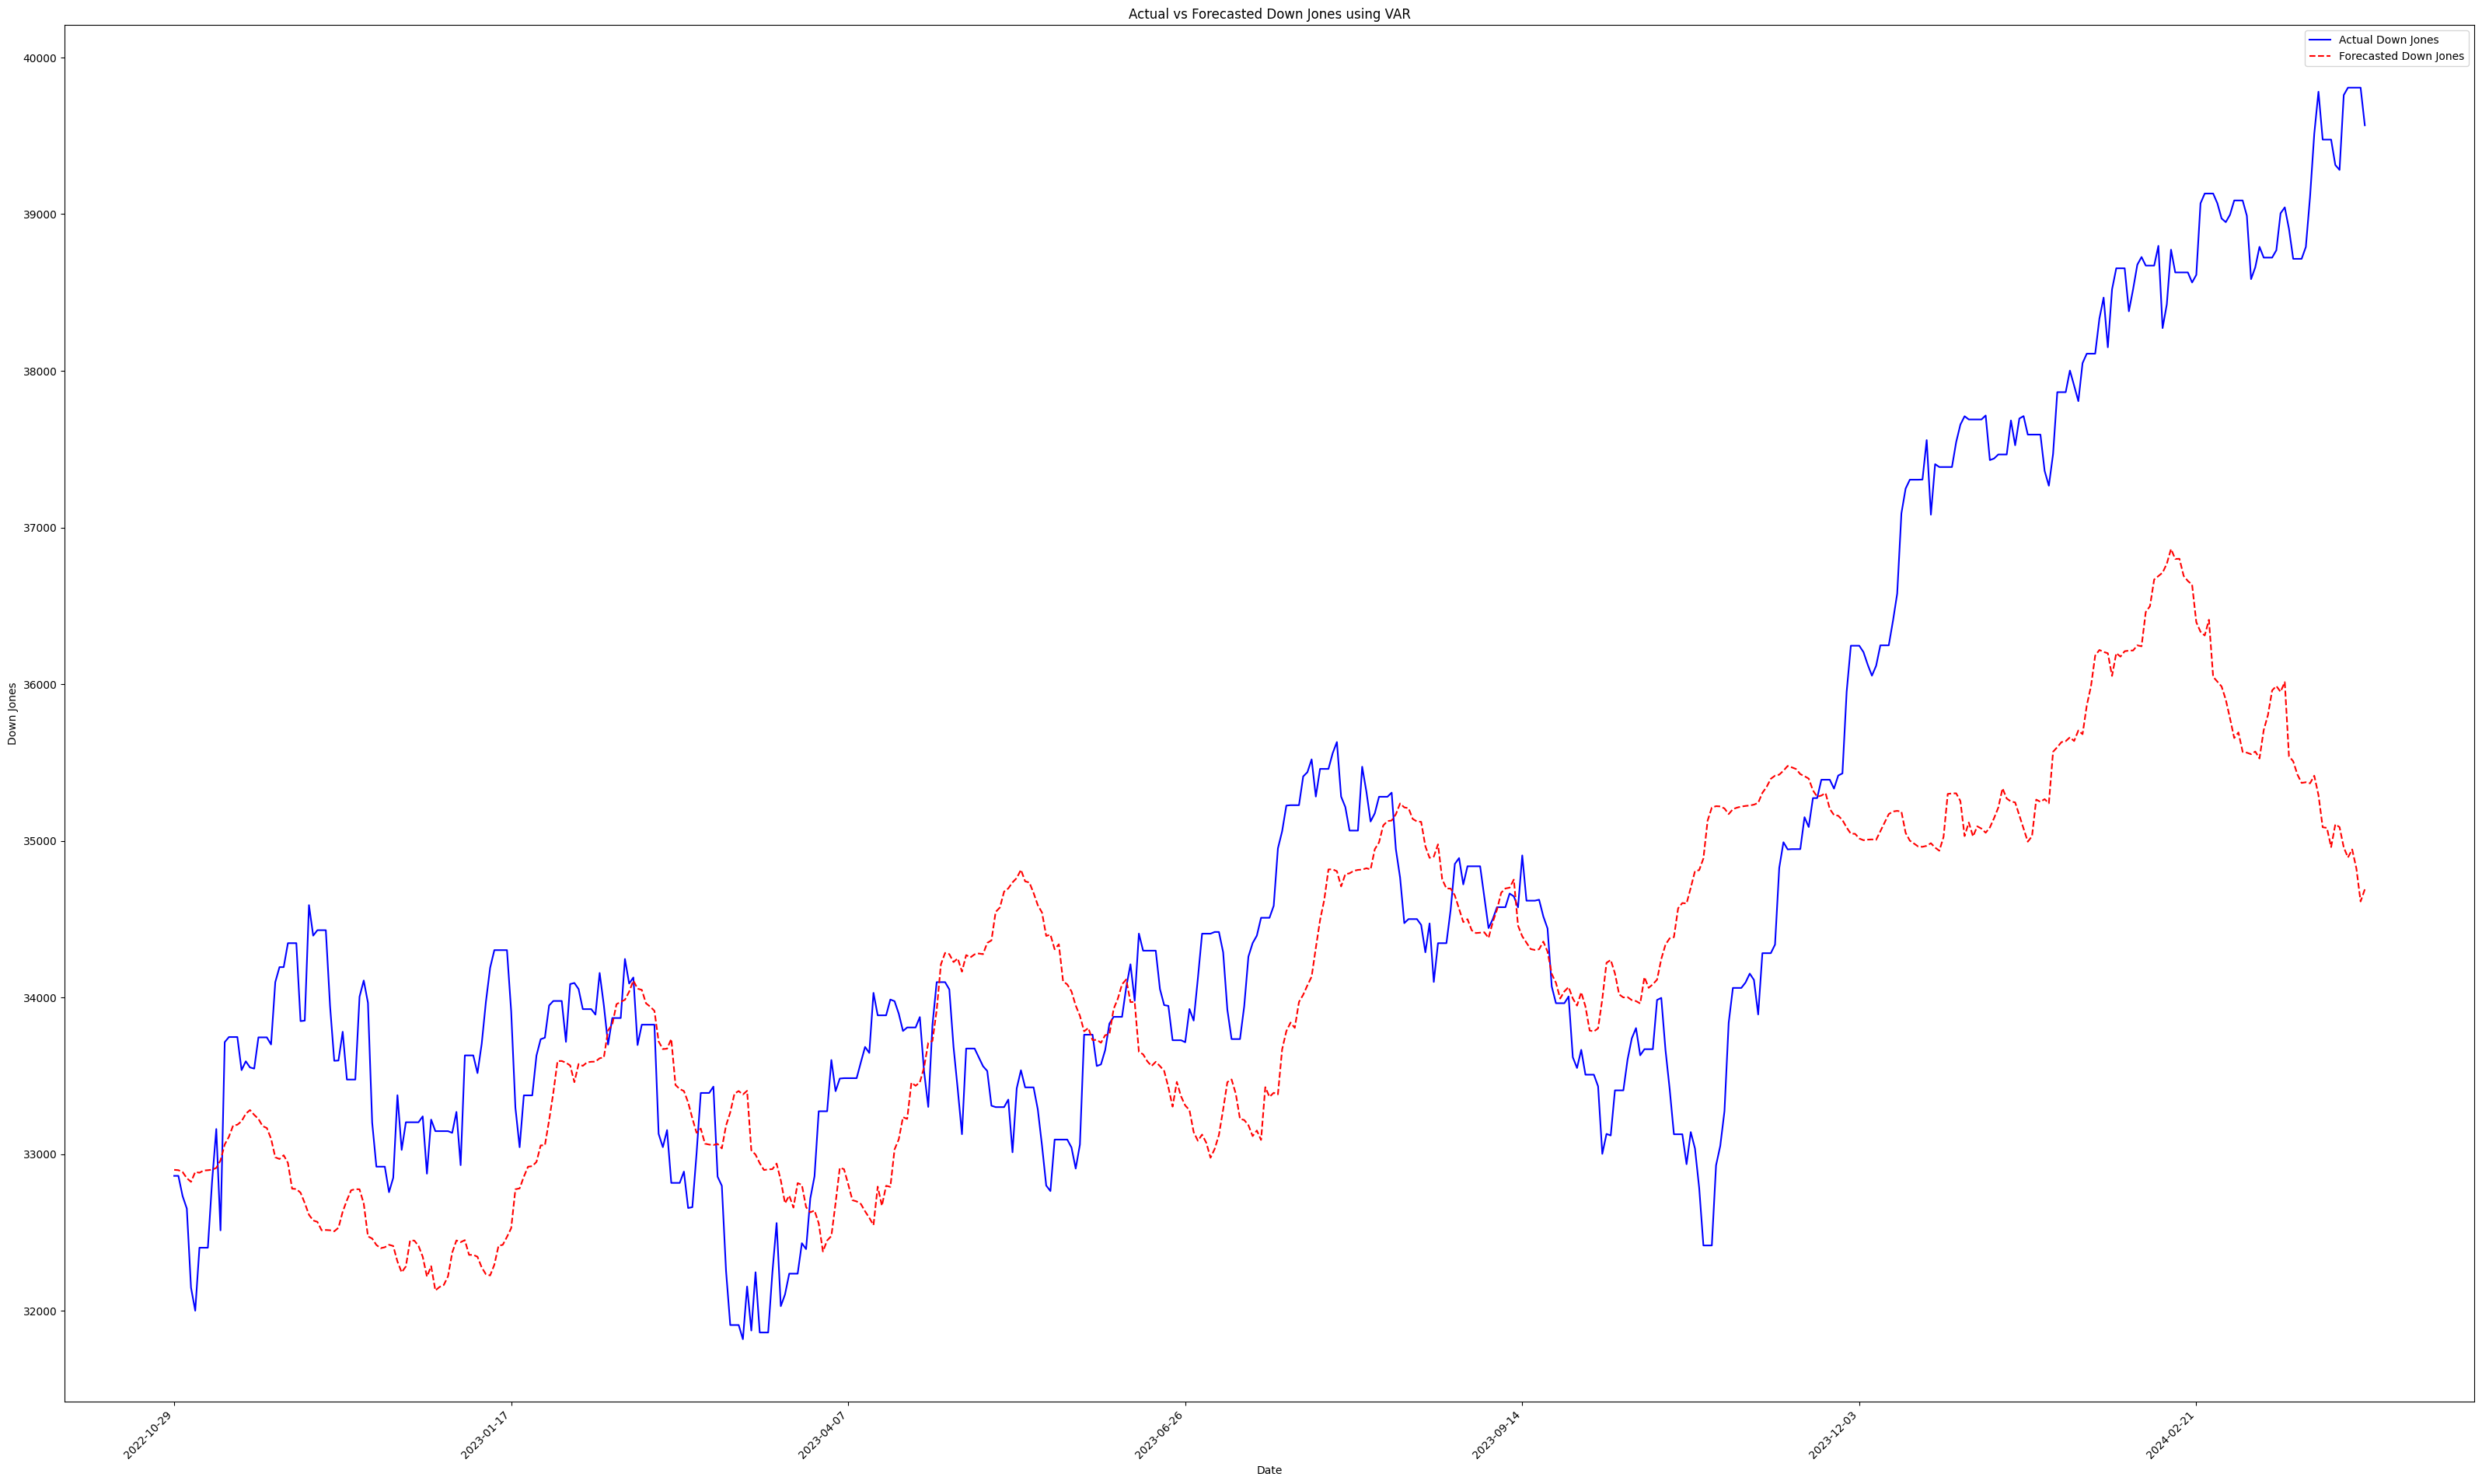

In [38]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
columns = ['GDP', 'GPDI', 'NETEXP', 'GovTotExp', 'ImpGoServ', 'ExpGoServ', 'Unempl', 'PCE', 'ProPriceInd', '10yIntRate', 'GloWheat', 'GloUranium', 'GloPalmOil', 'Real_Estate_Loans', 'SP500','Dow_Jones_Target', 'NASDAQ', 'Federal_Debt']

data_diff = econ_data[columns]

split_index = int(len(data_diff) * 0.85) #this determines the lentgh of the forecast, according to this I can adjust the Date_col lentgh
train_data = data_diff.iloc[:split_index]
test_data = data_diff.iloc[split_index:]

model = VAR(train_data)
results = model.fit(maxlags=2820) #resulting from the grangercausalitytests --> for GDP = maxlags=87////2820

forecast_steps = len(test_data)
forecast = results.forecast(train_data.values[-results.k_ar:], steps=forecast_steps)


forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=columns)


dowjones_forecast = forecast_df['Dow_Jones_Target']
dowjones_actual = test_data['Dow_Jones_Target']

#####################################################################FUN#####################################################
#####################################################################FUN#####################################################
# gdp_forecast = forecast_df['SP500']
# gdp_actual = test_data['SP500']
#####################################################################FUN#####################################################
#####################################################################FUN#####################################################
dates = data_diff.index[split_index:]


comparison_df = pd.DataFrame({'Date': Date_col, 'Actual Down Jones': dowjones_actual.values, 'Forecasted Down Jones': dowjones_forecast.values}) #'Date': Date_col, 'Actual GDP': gdp_actual.values
comparison_df.dropna(inplace=True)


mae = mean_absolute_error(comparison_df['Actual Down Jones'], comparison_df['Forecasted Down Jones'])
print(f"MAE: {mae:.2f}")

# def mean_absolute_percentage_error_smooth(y_true, y_pred, epsilon=1e-5):
#     return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# # Modify MAPE to exclude zero values in the actual GDP
# def mean_absolute_percentage_error(y_true, y_pred):
#     mask = y_true != 0  # Exclude zero values from the actuals
#     return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# def mean_absolute_percentage_error(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(comparison_df['Actual Down Jones'], comparison_df['Forecasted Down Jones'])
print(f"MAPE: {mape:.2f}%")


print("Dow Jones Actual vs Forecast:")
print(comparison_df)

plt.figure(figsize=(40, 23))
plt.plot(comparison_df['Date'], comparison_df['Actual Down Jones'], label='Actual Down Jones', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Forecasted Down Jones'], label='Forecasted Down Jones', color='red', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(9)) 
plt.xlabel('Date')
plt.ylabel('Down Jones')
plt.title('Actual vs Forecasted Down Jones using VAR')
plt.legend()
plt.savefig('actual_vs_forecasted_dow_jones_VAR_nodiff.pdf', format='pdf')
plt.show()

### Adjusting the Axis

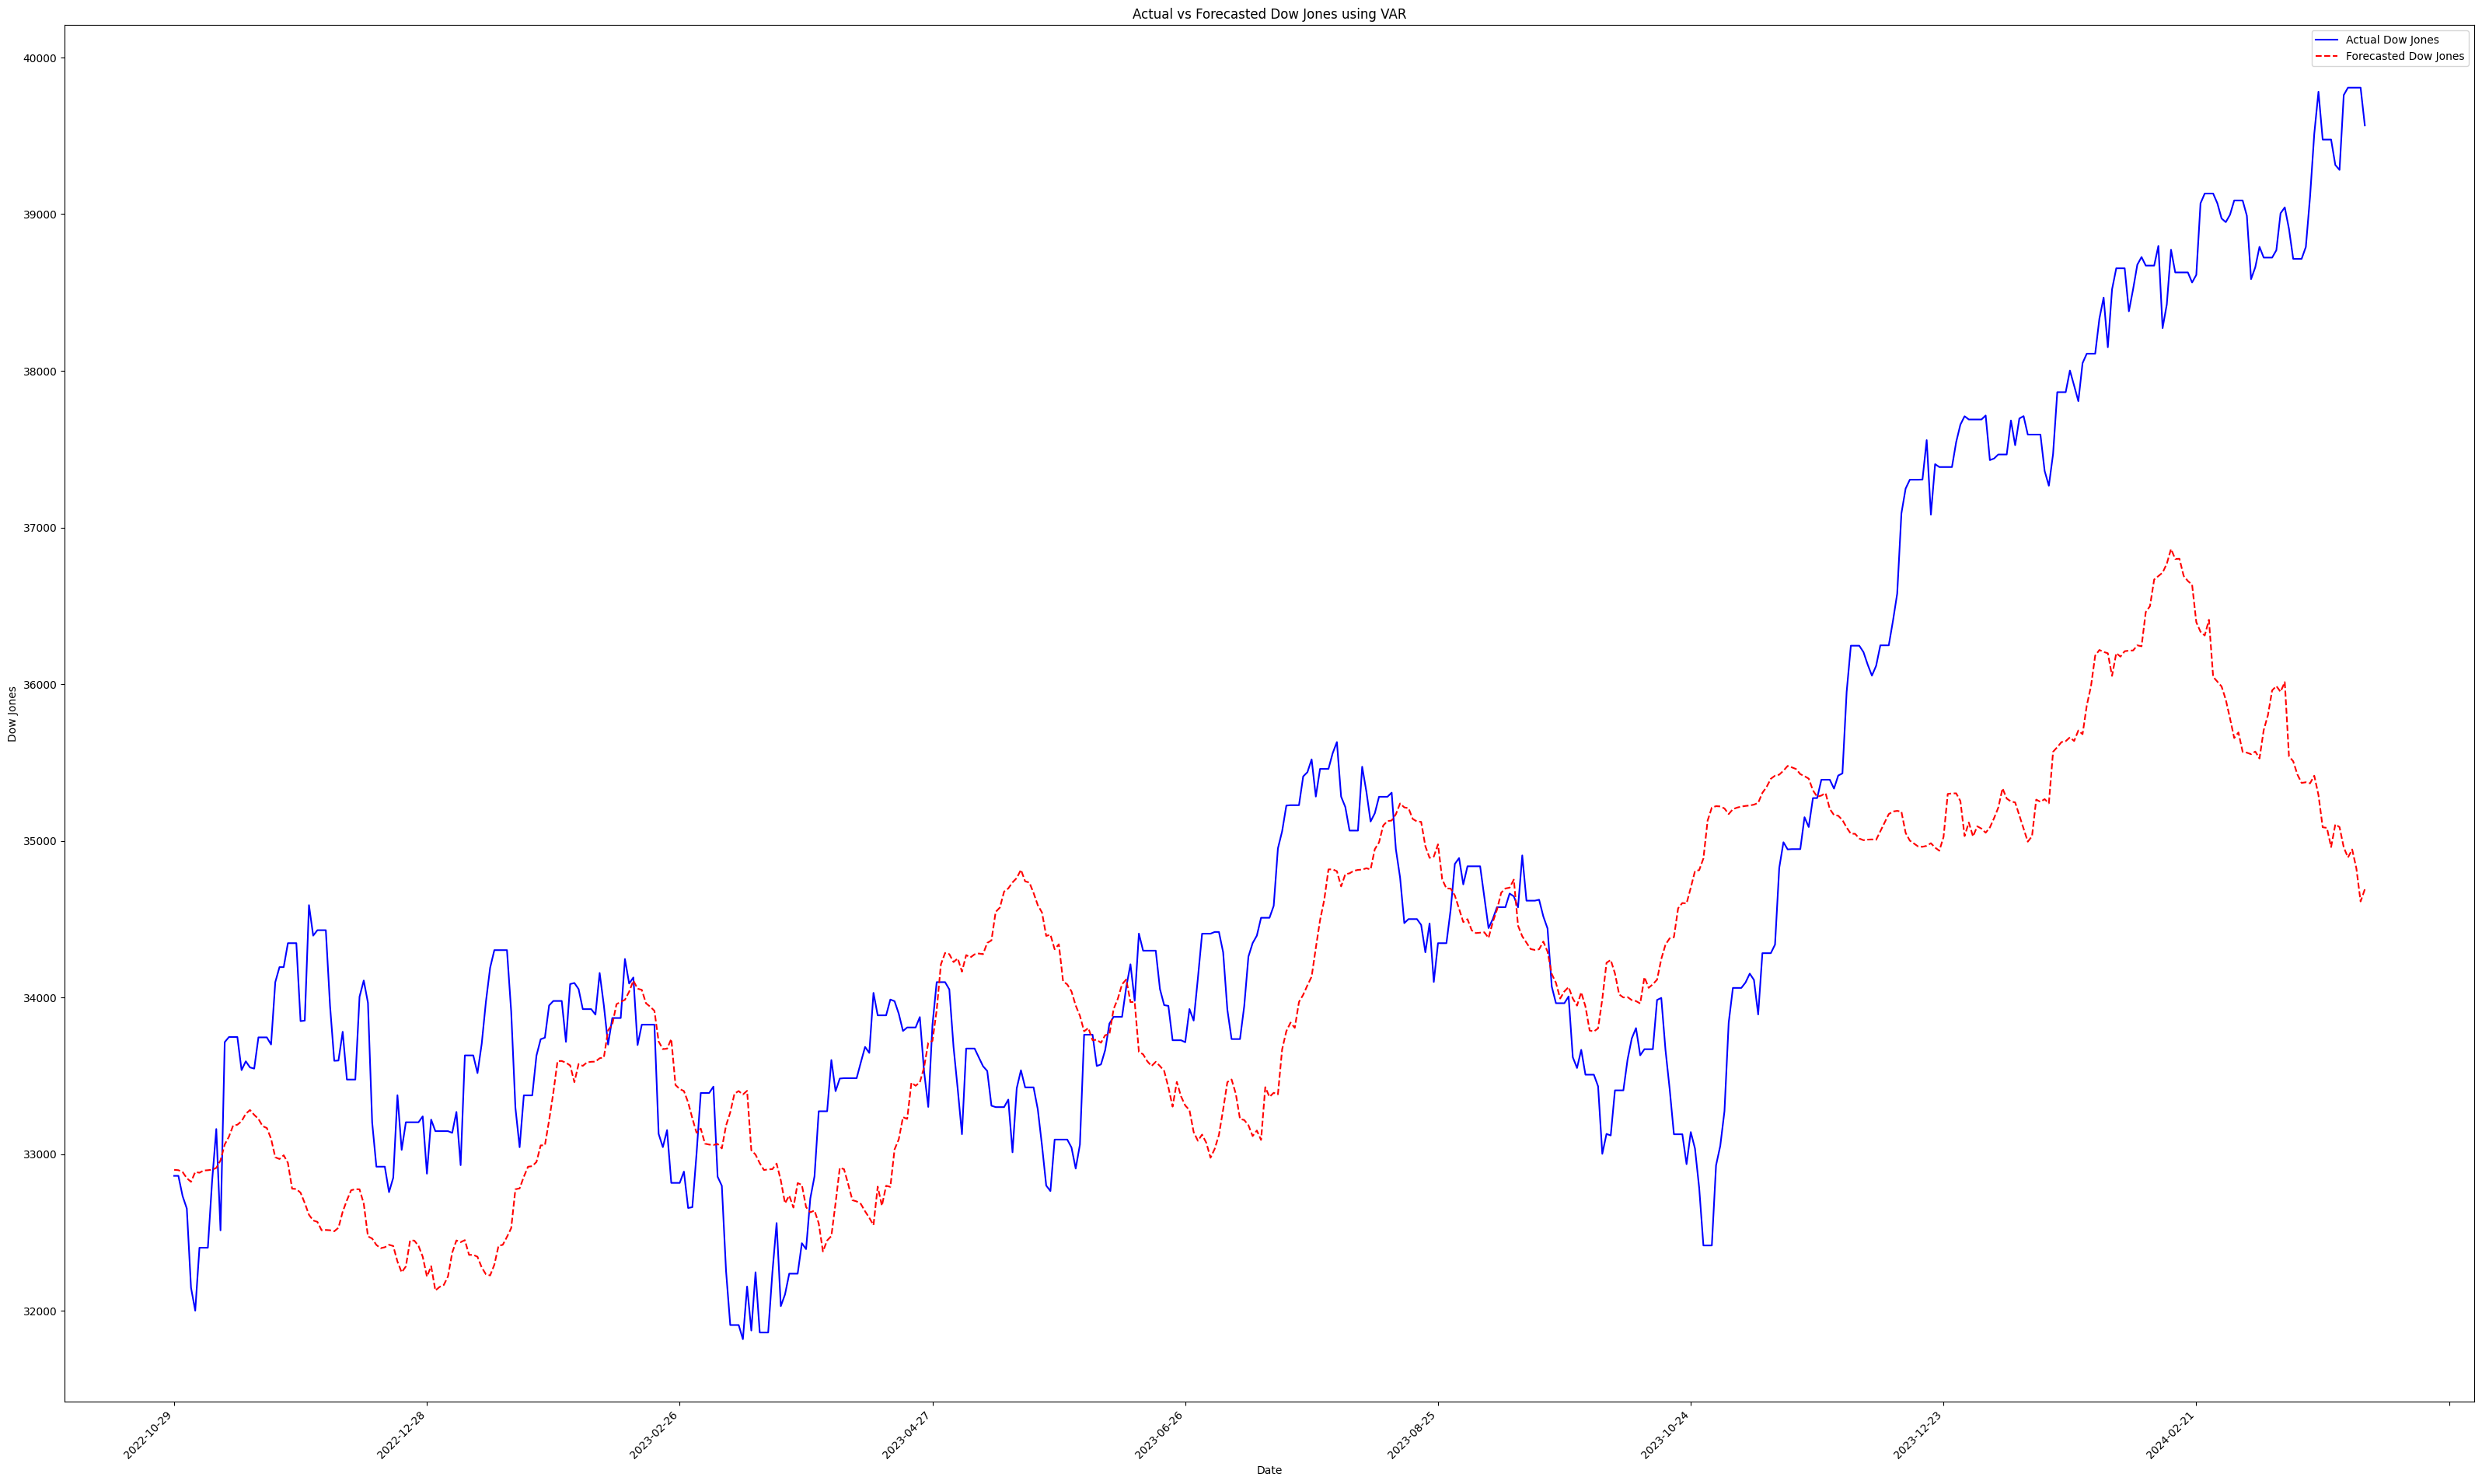

In [13]:
import matplotlib.pyplot as plt

# Adjust the figure size as needed
plt.figure(figsize=(40, 23))

# Plot the actual and forecasted values
plt.plot(comparison_df['Date'], comparison_df['Actual Down Jones'], label='Actual Dow Jones', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Forecasted Down Jones'], label='Forecasted Dow Jones', color='red', linestyle='--')

# Rotate the x-axis labels to make them readable
plt.xticks(rotation=45, ha='right')

# Optionally, reduce the number of x-axis ticks for readability (by showing every nth date)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust 10 to the number of ticks you want to display

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Dow Jones')
plt.title('Actual vs Forecasted Dow Jones using VAR')

# Add a legend
plt.legend()

# Save the plot as a PDF
plt.savefig('actual_vs_forecasted_dow_jones_VAR_nodiff_improved.pdf', format='pdf')

# Show the plot
plt.show()


### Results

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(comparison_df['Actual Down Jones'], comparison_df['Forecasted Down Jones'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(comparison_df['Actual Down Jones'], comparison_df['Forecasted Down Jones'])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAPE
mape = mean_absolute_percentage_error(comparison_df['Actual Down Jones'], comparison_df['Forecasted Down Jones'])
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')


Mean Absolute Error (MAE): 1169.6284017202127
Mean Squared Error (MSE): 2394912.2895625234
Root Mean Squared Error (RMSE): 1547.5504158386968
Mean Absolute Percentage Error (MAPE): 3.25%


### Ljung-Box test ✅

Why it is okay to use different time lags in the lb test compared to the fitting of the VAR model:\
Let’s say you fit the VAR model using 2820 lags, which is quite high. Testing the residuals with fewer lags (e.g., 10 or 20) for autocorrelation is a reasonable approach because you're primarily interested in detecting any significant patterns that remain uncaptured by the model at shorter lag intervals.\


In [32]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'train_data' is your dataset with time series variables
# Fit the VAR model
model = VAR(train_data)
results = model.fit(maxlags=15)  # You can adjust the maxlags based on your data

# Get the residuals from the fitted model
residuals = results.resid

# Perform the Ljung-Box test on the residuals for each variable
# Set the number of lags for the Ljung-Box test (you can adjust the lags)
lags = 15
ljung_box_results = {}

# Apply Ljung-Box test to each column (time series) in the residuals DataFrame
for column in residuals.columns:
    lb_test = acorr_ljungbox(residuals[column], lags=[lags], return_df=True)
    ljung_box_results[column] = lb_test

# Print the Ljung-Box test results
for var, lb_result in ljung_box_results.items():
    print(f"Ljung-Box test for residuals of {var}:")
    print(lb_result)
    print("\n")


Ljung-Box test for residuals of GDP:
      lb_stat  lb_pvalue
15  13.493144   0.564264


Ljung-Box test for residuals of GPDI:
      lb_stat  lb_pvalue
15  12.657613   0.628725


Ljung-Box test for residuals of NETEXP:
     lb_stat  lb_pvalue
15  1.544908   0.999995


Ljung-Box test for residuals of GovTotExp:
     lb_stat  lb_pvalue
15  9.100172   0.872222


Ljung-Box test for residuals of ImpGoServ:
      lb_stat  lb_pvalue
15  11.355259   0.727028


Ljung-Box test for residuals of ExpGoServ:
      lb_stat  lb_pvalue
15  10.778013   0.768166


Ljung-Box test for residuals of Unempl:
      lb_stat  lb_pvalue
15  19.393325    0.19646


Ljung-Box test for residuals of PCE:
     lb_stat  lb_pvalue
15  6.279528    0.97466


Ljung-Box test for residuals of ProPriceInd:
     lb_stat  lb_pvalue
15  8.166354    0.91694


Ljung-Box test for residuals of 10yIntRate:
     lb_stat  lb_pvalue
15  0.545843        1.0


Ljung-Box test for residuals of GloWheat:
     lb_stat  lb_pvalue
15  1.945133  

 No Autocorrelation in Residuals

Autocorrelation in the residuals means that the residuals are correlated with their past values, indicating that the model hasn’t captured all relevant information.

In [50]:
# from statsmodels.stats.diagnostic import acorr_ljungbox

# # Get residuals from the VAR model
# residuals = results.resid

# # Apply Ljung-Box test to each column (each variable's residuals)
# for column in residuals.columns:
#     print(f"Ljung-Box test for residuals of {column}:")
#     ljung_box_results = acorr_ljungbox(residuals[column], lags=[15], return_df=True)
#     print(ljung_box_results)
#     print("\n")


Most of the variables (including GDP, Dow_Jones_Target, SP500, etc.) show no significant autocorrelation in the residuals, meaning that your model has done a good job capturing the relationships for those variables

p-value > 0.05: Fail to reject the null hypothesis — no significant autocorrelation in the residuals (i.e., the residuals are white noise).

### Check for homoscedasricity ✅

In [51]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Get residuals and drop first k_ar rows from the training data
k_ar = results.k_ar
residuals = results.resid

# Drop the first k_ar rows from the training data to match residuals size
aligned_train_data = train_data.iloc[k_ar:]

# Add constant to the training data
exog = sm.add_constant(aligned_train_data)

# Breusch-Pagan test for heteroscedasticity in Dow_Jones_Target residuals
bp_test = het_breuschpagan(residuals['Dow_Jones_Target'], exog)

# bp_test contains 4 elements: Lagrange multiplier statistic, p-value, f-value, f p-value
print(f"Lagrange Multiplier statistic: {bp_test[0]}")
print(f"p-value: {bp_test[1]}")



Lagrange Multiplier statistic: 18.91590570181178
p-value: 0.3970191141671576


Since your p-value (0.397) is well above 0.05, this indicates that the residuals for Dow_Jones_Target do not suffer from heteroscedasticity, which is a good sign for the validity of your model.\
This, combined with your other diagnostic checks (like the Ljung-Box test), suggests that the model is performing well in terms of assumptions for this variable.

### Stationarity of residuals ❌

In [17]:
from statsmodels.tsa.stattools import adfuller

# Example: using residuals from the 'Dow_Jones_Target' column
adf_result = adfuller(residuals['Dow_Jones_Target'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -1.8184708324348355
p-value: 0.37133076033045465


The p-value is 0.371, which is greater than 0.05, meaning the residuals are non-stationary.\
As a consequence: Increase Lags: Sometimes increasing the number of lags in the model can help capture the dynamics better and may result in stationary residuals.


### Normality of residuals ❌

In [18]:
from statsmodels.stats.stattools import jarque_bera

# Example: using residuals from the 'Dow_Jones_Target' column
jb_test = jarque_bera(residuals['Dow_Jones_Target'])
print(f"Jarque-Bera statistic: {jb_test[0]}")
print(f"p-value: {jb_test[1]}")


Jarque-Bera statistic: 30.024878966215613
p-value: 3.021206236951649e-07


The p-value is extremely small (3.02e-07), which is far below 0.05, meaning that you reject the null hypothesis. This indicates that the residuals are not normally distributed

Non-normal residuals are a signal that the model may not be fitting the data perfectly. While VAR models do not strictly require normally distributed residuals, significant deviations from normality can affect inference and forecast accuracy